In [2]:
import keras
import tensorflow as tf
import tensorflow_addons as tfa
import keras_wrn

import matplotlib.pyplot as plt

from keras.optimizers import SGD

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

shape, classes = (32, 32, 3), 10

170500096/170498071 [==============================] - 20s 0us/step


In [79]:
import numpy as np
threshold = 0.0001

def weights_diff(model1, model2):
    model_diff = []
    layer_sizes = []
    for i in range(len(model1.layers)):
      if len(model1.layers[i].get_weights()) > 0:
#         print("Layer " + str(i + 1) + ":")
        layer_diff = model1.layers[i].get_weights()[0] - model2.layers[i].get_weights()[0]
        model_diff.append(layer_diff)
#         print(layer_diff)
    for i in range(len(model_diff)):
      current_layer_size = 0
      total_nonzero = 0
      max = 0
      for cell in np.nditer(model_diff[i]):
        current_layer_size += 1
        if abs(cell) > 0.001:
          total_nonzero += 1
          if abs(cell) > max:
            max = cell
      percentage_diff = ((total_nonzero * 1.) / current_layer_size) * 100
      print("Amount of different weights in Layer " + str(i + 1) + ": " + str(total_nonzero)
            + " / " + str(current_layer_size) + " (" + str(percentage_diff) + "%)")
      print("Maximum Difference in Layer " + str(i+1) + ": " + str(max))
      layer_sizes.append(current_layer_size)

        
def weights_diff_stats(model1, model2, threshold):
    model_diff = []
    layer_sizes = []
    for i in range(len(model1.layers)):
      if len(model1.layers[i].get_weights()) > 0:
#         print("Layer " + str(i + 1) + ":")
        layer_diff = model1.layers[i].get_weights()[0] - model2.layers[i].get_weights()[0]
        model_diff.append(layer_diff)
#         print(layer_diff)
    res = []
    for i in range(len(model_diff)):
      current_layer_size = 0
      total_nonzero = 0
      max = 0
      for cell in np.nditer(model_diff[i]):
        current_layer_size += 1
        if abs(cell) > threshold:
          total_nonzero += 1
          if abs(cell) > max:
            max = cell
      percentage_diff = ((total_nonzero * 1.) / current_layer_size) * 100
      res.append(percentage_diff)
#       print("Amount of different weights in Layer " + str(i + 1) + ": " + str(total_nonzero)
#             + " / " + str(current_layer_size) + " (" + str(percentage_diff) + "%)")
#       print("Maximum Difference in Layer " + str(i+1) + ": " + str(max))
      layer_sizes.append(current_layer_size)
    return res

def epoch_weight_diff(m1_prefix, m2_prefix):
    res = []
    for i in [50, 100]:
        t = 'model_ckpt/{}-{}'.format(m1_prefix, str(i).zfill(2))
        s = '{}-{}'.format(m2_prefix, str(i).zfill(2))

        m1 = tf.keras.models.load_model(t)
        m2 = tf.keras.models.load_model(s)

        stats = weights_diff_stats(m1, m2)
        res.append(stats)
    
    lines = []
    for j in range(len(res[0])):
        line = []
        for i in range(len(res)):
            line.append(res[i][j])
        lines.append(line)
    return lines

def single_threshold(th, m1, m2, save=None):
    stats = weights_diff_stats(m1, m2, th)

    fig = plt.figure()
    ax = fig.add_axes([0,0,2,2])
    layers = [f"{i}" for i in range(len(stats))]
    ax.bar(layers,stats)

    ax.set_xlabel("layers")
    ax.set_ylabel('% difference > {}'.format(threshold))

    plt.show()
    if save is not None:
        fig.savefig(save.format(threshold), bbox_inches='tight', dpi=300)

def multiple_thresholds(th, m1, m2, save=None):
#     th = [0.01, 0.001, 0.0001]
    # weights_diff(m1, m2)
    stats = weights_diff_stats(m1, m2, 0.01)
    stats1 = weights_diff_stats(m1, m2, 0.001)
    stats2 = weights_diff_stats(m1, m2, 0.0001)

    st = [stats, stats1, stats2]
    fig, axs = plt.subplots(1,3, figsize=(30, 5), sharex=True, sharey=True)
    for i, ax in enumerate(axs.flat):
        layers = [f"{i}" for i in range(len(st[i]))]
        ax.barh(layers,st[i])
        ax.set_title('Threshold = {}'.format(th[i]))

    # set labels
    plt.setp(axs[:], xlabel='% difference > threshold')
    plt.setp(axs[:], ylabel='Layers')

    fig = plt.figure(figsize=(30,10))

    plt.show()
    if save is not None:
        fig.savefig(save.format(threshold), bbox_inches='tight', dpi=300)

# Resnet Models depth 28, width 2

## Experiment 1 - Models trained for 140 epochs with SGDW

In [31]:
m1 = tf.keras.models.load_model('models/1_resnet_28_2')
m2 = tf.keras.models.load_model('models/2_resnet_28_2')
m3 = tf.keras.models.load_model('models/3_resnet_28_2')

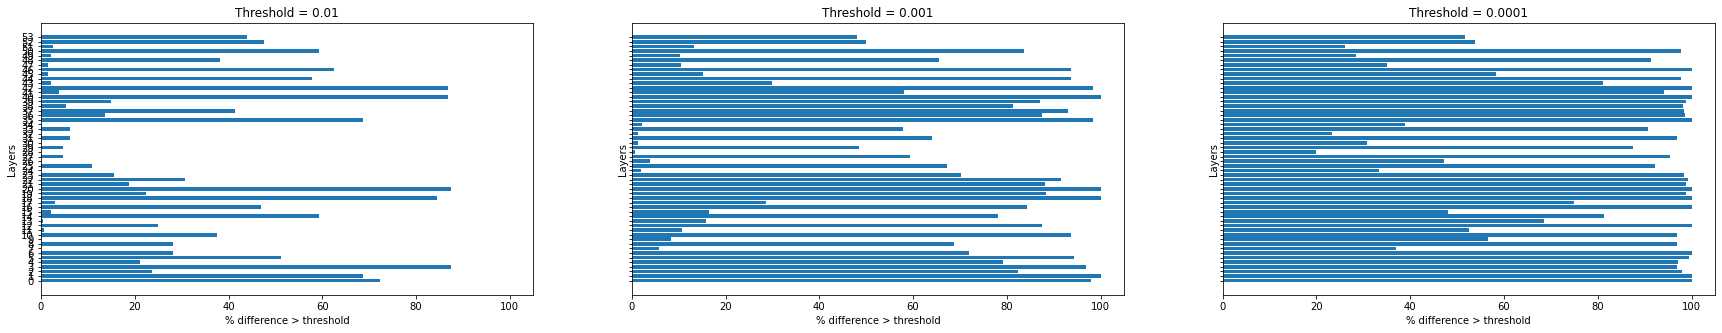

<Figure size 2160x720 with 0 Axes>

In [80]:
multiple_thresholds([0.01, 0.001, 0.0001], m1, m2)

In [83]:
m1.evaluate(x_test, y_test)
m2.evaluate(x_test, y_test)

313/313 [==============================] - 41s 130ms/step - loss: 0.8381 - accuracy: 0.7859


[0.8381226658821106, 0.7858999967575073]

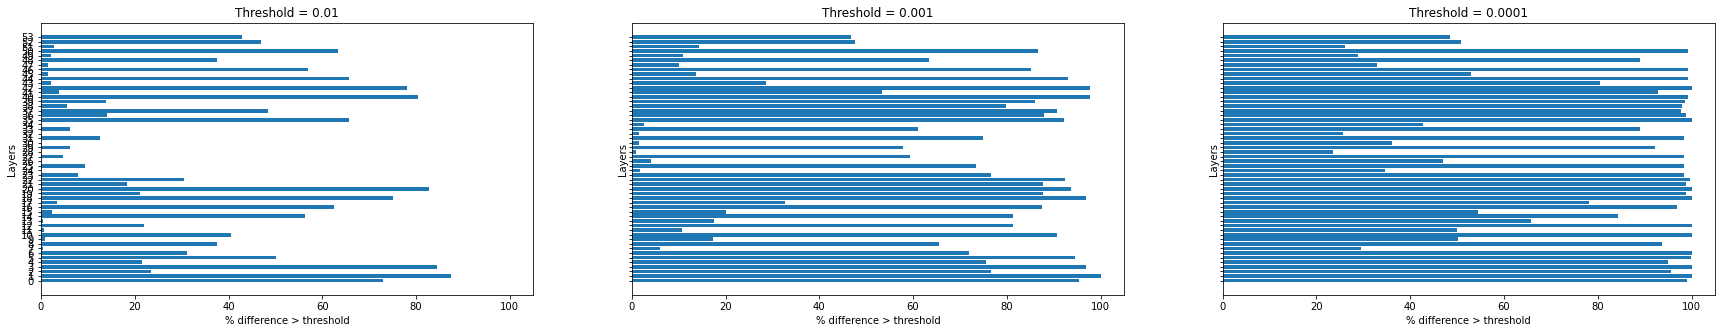

<Figure size 2160x720 with 0 Axes>

In [82]:
multiple_thresholds([0.01, 0.001, 0.0001], m2, m3)

In [84]:
m2.evaluate(x_test, y_test)
m3.evaluate(x_test, y_test)

313/313 [==============================] - 43s 137ms/step - loss: 1.4883 - accuracy: 0.5501


[1.4883079528808594, 0.5501000285148621]

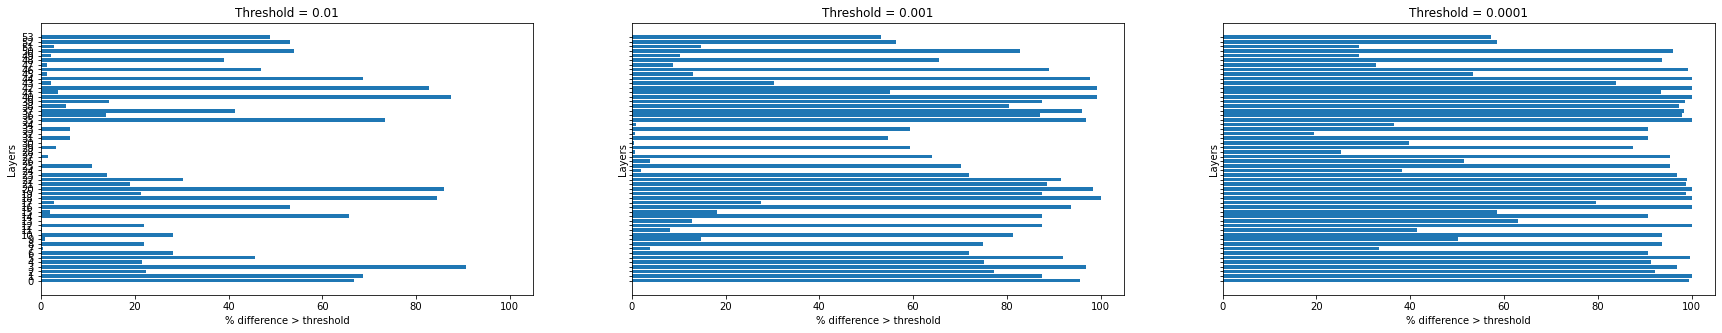

<Figure size 2160x720 with 0 Axes>

In [85]:
multiple_thresholds([0.01, 0.001, 0.0001], m1, m3)

In [86]:
m1.evaluate(x_test, y_test)
m3.evaluate(x_test, y_test)

313/313 [==============================] - 44s 142ms/step - loss: 1.4883 - accuracy: 0.5501


[1.4883079528808594, 0.5501000285148621]

In [10]:
y1 = m1.predict(x_test)
y2 = m2.predict(x_test)
y3 = m3.predict(x_test)

In [11]:
y = (y1 + y2 + y3) / 3
y = np.argmax(y, axis=1)
t_y = np.argmax(y_test, axis=1)

1 - np.count_nonzero(np.abs(y - t_y))/y.shape[0]

0.8028

## Experiment 2 - Models trained for 140 epochs with SGD

In [40]:
k1 = tf.keras.models.load_model('models/SGD_1_resnet_28_2')
k2 = tf.keras.models.load_model('models/SGD_2_resnet_28_2')
k3 = tf.keras.models.load_model('models/SGD_3_cont_resnet_28_2')

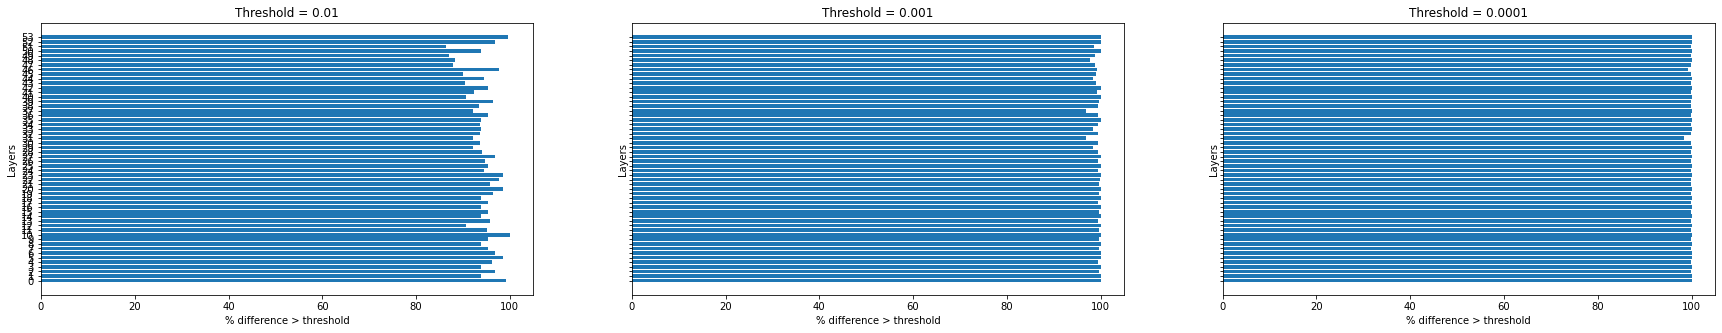

<Figure size 2160x720 with 0 Axes>

In [87]:
multiple_thresholds([0.01, 0.001, 0.0001], k1, k2)

In [88]:
k1.evaluate(x_test, y_test)
k2.evaluate(x_test, y_test)

313/313 [==============================] - 50s 160ms/step - loss: 0.9006 - accuracy: 0.8710


[0.900629997253418, 0.8709999918937683]

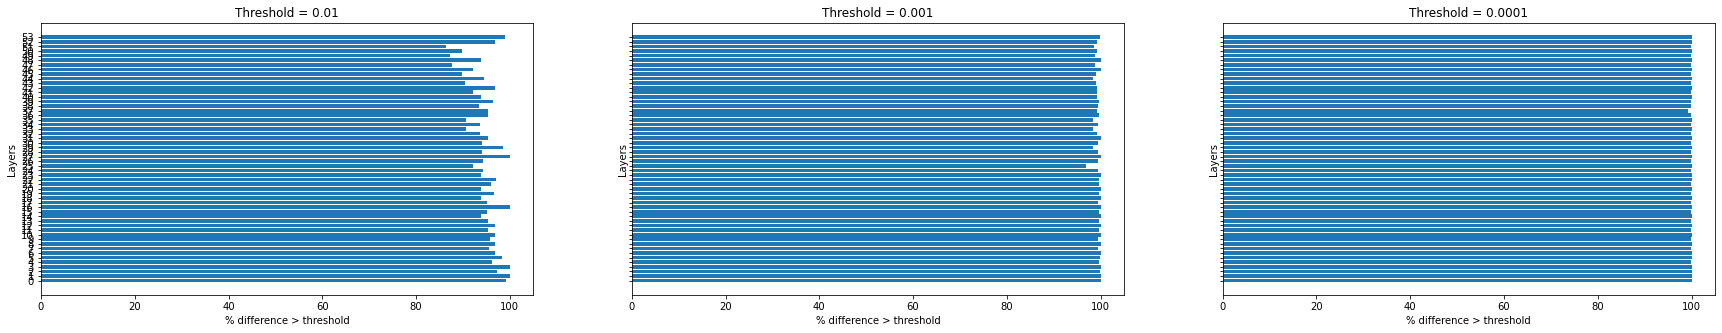

<Figure size 2160x720 with 0 Axes>

In [89]:
multiple_thresholds([0.01, 0.001, 0.0001], k2, k3)

In [90]:
k2.evaluate(x_test, y_test)
k3.evaluate(x_test, y_test)

313/313 [==============================] - 51s 164ms/step - loss: 0.9041 - accuracy: 0.8740


[0.9041303992271423, 0.8740000128746033]

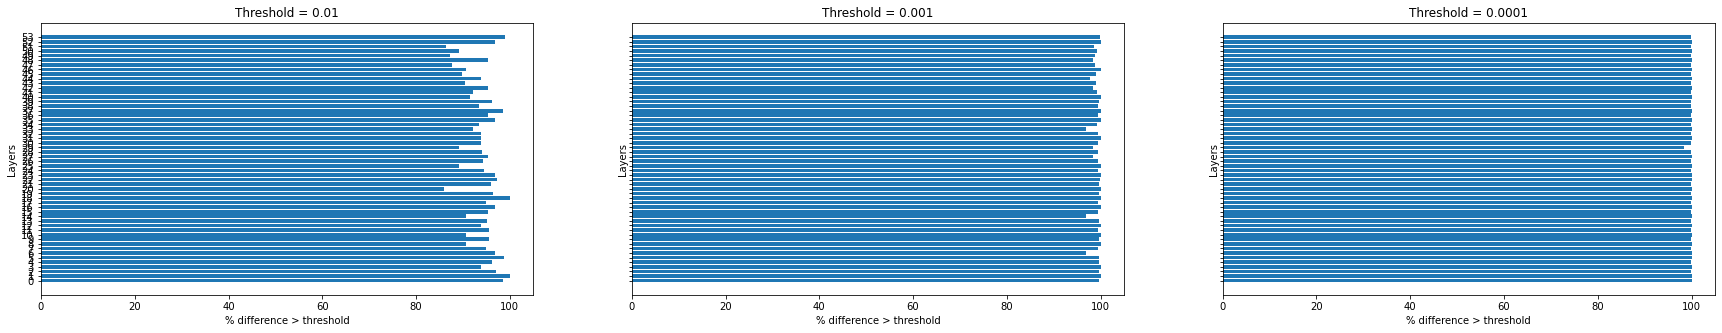

<Figure size 2160x720 with 0 Axes>

In [91]:
multiple_thresholds([0.01, 0.001, 0.0001], k1, k3)

In [92]:
k1.evaluate(x_test, y_test)
k3.evaluate(x_test, y_test)

313/313 [==============================] - 47s 149ms/step - loss: 0.9041 - accuracy: 0.8740


[0.9041303992271423, 0.8740000128746033]

In [16]:
y1 = k1.predict(x_test)
y2 = k2.predict(x_test)
y3 = k3.predict(x_test)

In [17]:
y = (y1 + y2 + y3) / 3
y = np.argmax(y, axis=1)
t_y = np.argmax(y_test, axis=1)

1 - np.count_nonzero(np.abs(y - t_y))/y.shape[0]

0.8927

## Experiment 3 - checkpointed models at epoch 50 for SGDW

In [100]:
# Check the checkpointed models at epoch 50 for SGDW

c1 = tf.keras.models.load_model('model_ckpt/1_resnet_28_2_50')
c2 = tf.keras.models.load_model('model_ckpt/2_resnet_28_2_50')
c3 = tf.keras.models.load_model('model_ckpt/3_resnet_28_2_50')

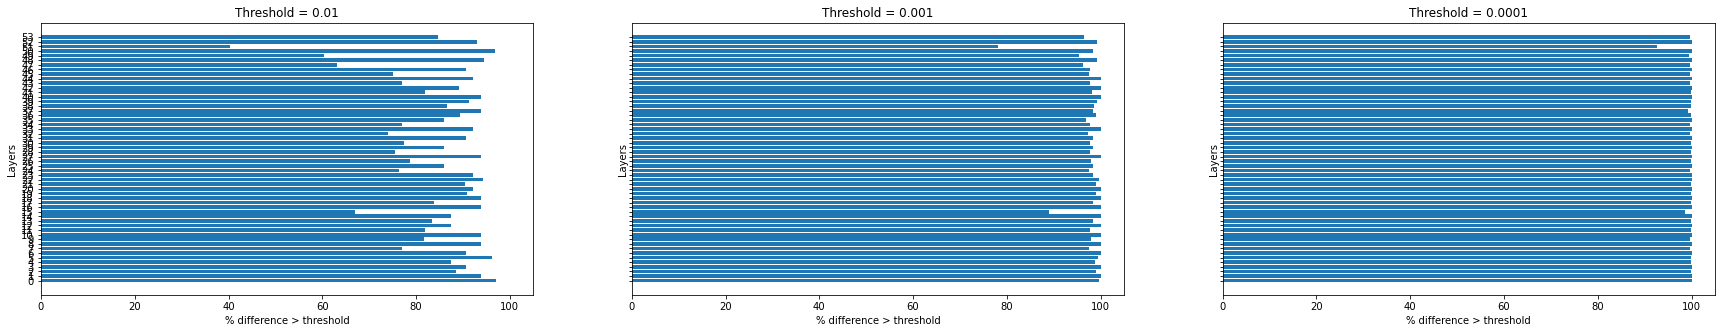

<Figure size 2160x720 with 0 Axes>

In [101]:
multiple_thresholds([0.01, 0.001, 0.0001], c1, c2)

In [102]:
c1.evaluate(x_test, y_test)
c2.evaluate(x_test, y_test)

313/313 [==============================] - 47s 151ms/step - loss: 1.7014 - accuracy: 0.5711


[1.701445460319519, 0.5710999965667725]

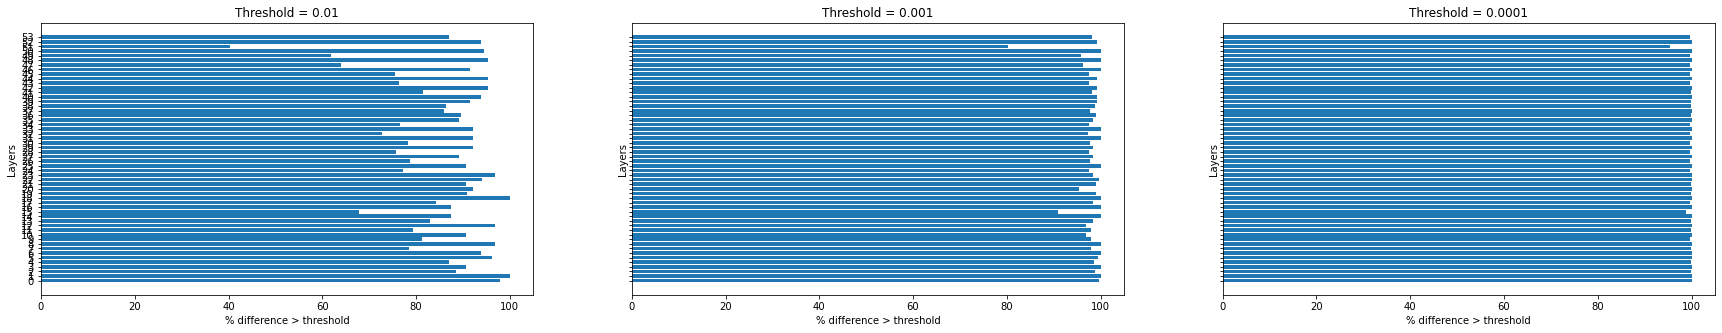

<Figure size 2160x720 with 0 Axes>

In [103]:
multiple_thresholds([0.01, 0.001, 0.0001], c2, c3)

In [104]:
c2.evaluate(x_test, y_test)
c3.evaluate(x_test, y_test)

313/313 [==============================] - 50s 160ms/step - loss: 1.5861 - accuracy: 0.5740


[1.5861197710037231, 0.5740000009536743]

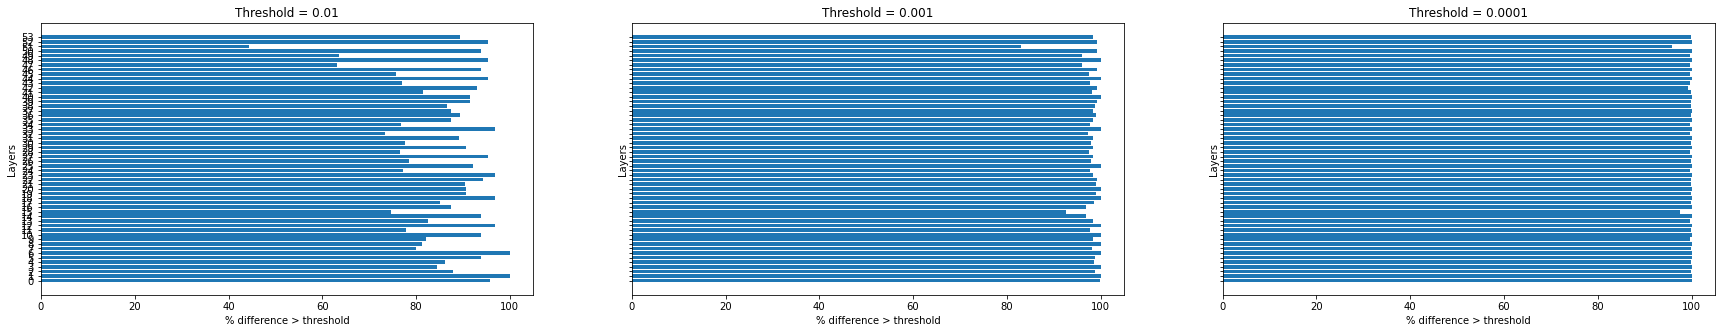

<Figure size 2160x720 with 0 Axes>

In [105]:
multiple_thresholds([0.01, 0.001, 0.0001], c1, c3)

In [106]:
c1.evaluate(x_test, y_test)
c3.evaluate(x_test, y_test)

313/313 [==============================] - 48s 154ms/step - loss: 1.5861 - accuracy: 0.5740


[1.5861197710037231, 0.5740000009536743]

## Experiment 4 - checkpointed models at epoch 100 for SGDW

In [107]:
# Check the checkpointed models at epoch 100 for SGDW

c1 = tf.keras.models.load_model('model_ckpt/1_resnet_28_2_100')
c2 = tf.keras.models.load_model('model_ckpt/2_resnet_28_2_100')
c3 = tf.keras.models.load_model('model_ckpt/3_resnet_28_2_100')

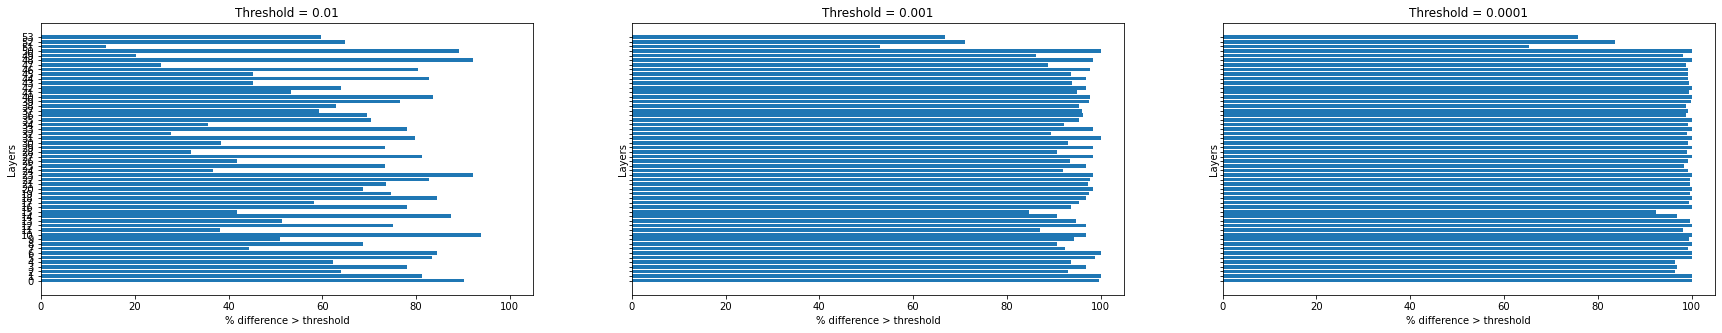

<Figure size 2160x720 with 0 Axes>

In [108]:
multiple_thresholds([0.01, 0.001, 0.0001], c1, c3)

In [109]:
c1.evaluate(x_test, y_test)
c2.evaluate(x_test, y_test)

313/313 [==============================] - 48s 154ms/step - loss: 0.6417 - accuracy: 0.8019


[0.6417401432991028, 0.8019000291824341]

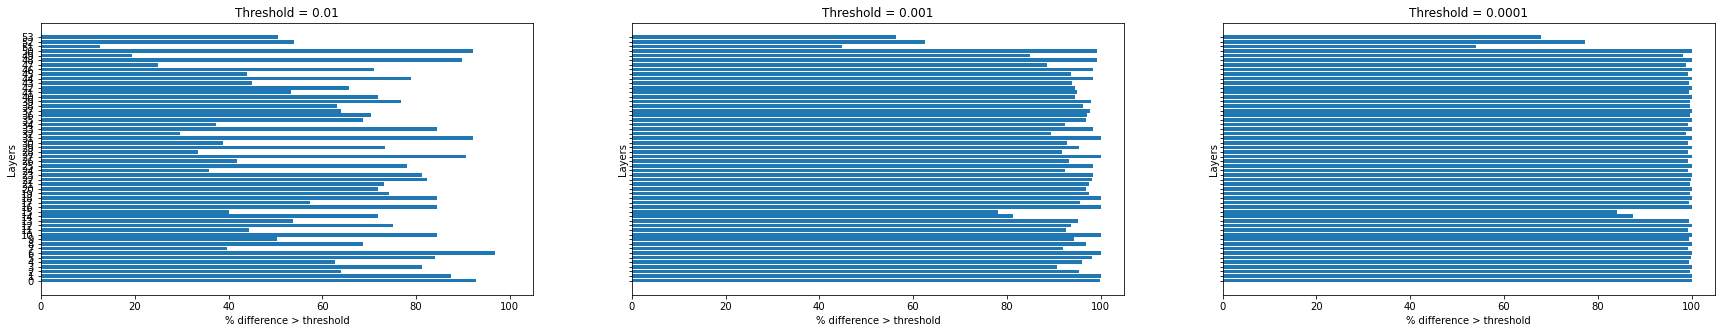

<Figure size 2160x720 with 0 Axes>

In [110]:
multiple_thresholds([0.01, 0.001, 0.0001], c2, c3)

In [111]:
c2.evaluate(x_test, y_test)
c3.evaluate(x_test, y_test)

313/313 [==============================] - 49s 157ms/step - loss: 0.7503 - accuracy: 0.7705


[0.7502716183662415, 0.7705000042915344]

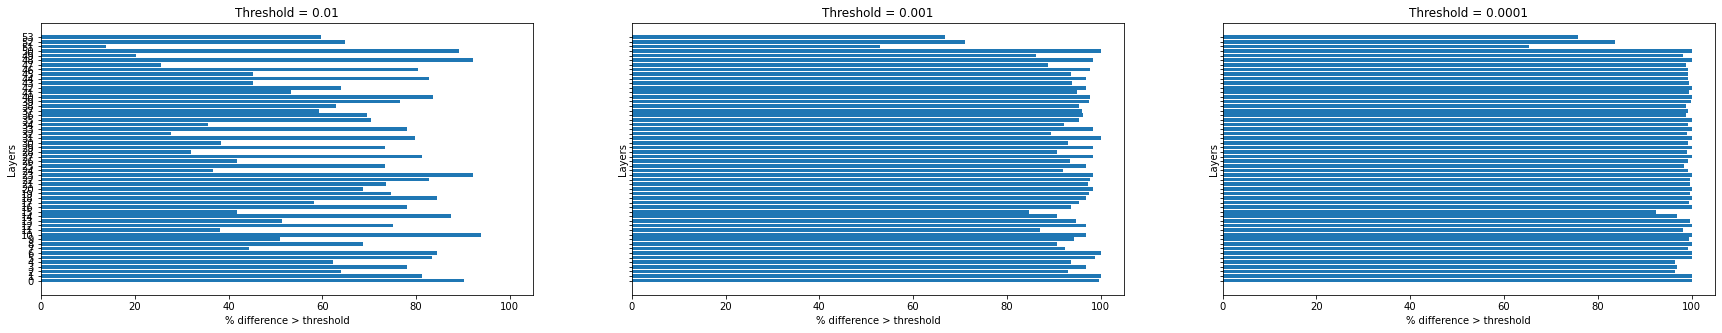

<Figure size 2160x720 with 0 Axes>

In [112]:
multiple_thresholds([0.01, 0.001, 0.0001], c1, c3)

In [113]:
c1.evaluate(x_test, y_test)
c3.evaluate(x_test, y_test)

313/313 [==============================] - 48s 153ms/step - loss: 0.7503 - accuracy: 0.7705


[0.7502716183662415, 0.7705000042915344]

In [29]:
y1 = c1.predict(x_test)
y2 = c2.predict(x_test)
y3 = c3.predict(x_test)

y = (y1 + y2 + y3) / 3
y = np.argmax(y, axis=1)
t_y = np.argmax(y_test, axis=1)

1 - np.count_nonzero(np.abs(y - t_y))/y.shape[0]

0.817